# Final Project

## Part 2a

Χρησιμοποιώντας τα απαραίτητα τμήματα του κώδικα από τη σελίδα https://github.com/maximoskp/MSc_LangTech_NKUA_DSP/blob/master/4_pitch_formants.ipynb να εξάγετε γραφήματα από τη θεμελιώδη συχνότητα και τους διαμορφωτές του κάθε φωνήεντος, καθώς και ένα συγκεντρωτικό γράφημα με boxplots για τις κατανομές των διαμορφωτών του κάθε φωνήεντος για τον κάθε ομιλητή.

In [283]:
from conch.analysis.formants import FormantTrackFunction
from conch.analysis.pitch import PitchTrackFunction
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

In [284]:
# define a function for extracting the desired features and for storing them in proper structures for further processing

def get_pitch_and_formants(f):
    func = PitchTrackFunction(time_step=0.01, min_pitch=75, max_pitch=600)
    pitch = func(f)
    func = FormantTrackFunction(time_step=0.01,
                                window_length=0.025, num_formants=5, max_frequency=5500)
    formants = func(f)
    # sync
    kp = np.array( list( pitch.keys() ) )
    kf = np.array( list( formants.keys() ) )
    
    synced = {}
    for t in kp:
        # find nearest value in formants
        idx = (np.abs( kf - t )).argmin()
        formants_freqs_list = []
        formants_ratios_list = []
        formants_amps_list = []
        current_pitch = pitch[ t ]
        if current_pitch[0] != 0:
            for fmnt in formants[ kf[ idx ] ]:
                if current_pitch[0] is not None and fmnt[0] is not None:
                    formants_freqs_list.append( fmnt[0] )
                    formants_amps_list.append( fmnt[1] )
                    formants_ratios_list.append( fmnt[0]/current_pitch[0] )
            synced[ t ] = {
                'pitch': pitch[ t ],
                'time': t,
                'formants_freqs': formants_freqs_list,
                'formants_amps': formants_amps_list,
                'formants_ratios': formants_ratios_list,
            }
    
    return synced, pitch, formants, kp, kf
# end get_pitch_and_formants

In [285]:
# define a function for ploting structures

def compount_pitch_formants_plot(file_name, pitch_formants, plt_alias, idx):
    y, sr = librosa.load(file_name, sr=44100)
    n_fft = 8096
    hop_size = 256
    p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
    d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
    librosa.display.specshow(d, cmap='gray_r', sr=sr, hop_length=hop_size, x_axis='time', y_axis='linear', ax=plt_alias)
    # and also, if we restrict to speech-relevant frequencies
    lowest_freq = 30
    highest_freq = 5000
    # plt_alias.ylim([lowest_freq, highest_freq])
    plt_alias.set_ylim([lowest_freq, highest_freq])
    plt_alias.title.set_text(f"Segment {idx+1}")
#     plt.tight_layout()
    
    # append pitch
    p = []
    t = []
    fmnts = []
    for k in list( pitch_formants.keys() ):
        a = pitch_formants[k]
        p.append( a['pitch'] )
        t.append( a['time'] )
        fmnts.append( a['formants_freqs'] )

    p = np.array( p )
    t = np.array( t )
    plt_alias.plot( t , p , 'r.' )
    for i in range( t.size ):
        for j in range( len(fmnts[i]) ):
            plt_alias.plot( t[i] , fmnts[i][j] , 'b.' )

<b>NOTES</b> 
<br>
<ul>
    <li> check <a href="https://www.enl.auth.gr/phonlab/Nicolaidis_spon_ac.pdf">Acoustic Variability of Vowels in Greek Spontaneous Speech</a> , φωνήεντα με τη μεγαλύτερη συχνότητα & διάρκεια, άρα /a/ & /e/
    <li> 4 segments of speaker 1 and then 4 segments of speaker 2
</ul>

In [328]:
# run for audio files
ah_pitch_formants = []
eh_pitch_formants = []

for speakerNum in range(2):
    for i in range(4):
        recNum = str(i+1)
        a, _, _, _, _ = get_pitch_and_formants( f'../Media/s{speakerNum+1}/a{recNum}_s{speakerNum+1}.wav')
        ah_pitch_formants.append( a )
        e, _, _, _, _ = get_pitch_and_formants( f'../Media/s{speakerNum+1}/e{recNum}_s{speakerNum+1}.wav')
        eh_pitch_formants.append( e )


# sachirp, _, _, tachirp, _ = get_pitch_and_formants( 'audio_files/ah/ah_chirp.wav' )
# sochirp, _, _, tochirp, _ = get_pitch_and_formants( 'audio_files/oh/oh_chirp.wav' )


> Speaker no.1:
Ah_1=22
Ah_2=19
Ah_3=14
Ah_4=19

> Speaker no.2:
Ah_1=18
Ah_2=26
Ah_3=29
Ah_4=20


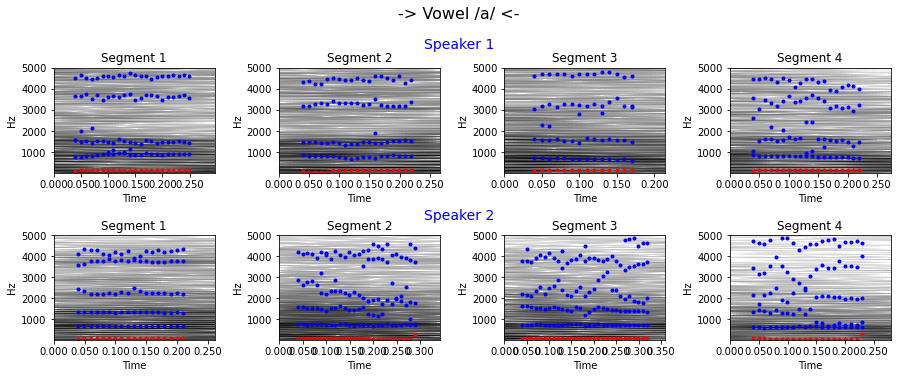

In [329]:
fig,a =  plt.subplots(2,4,figsize=(15,5))#,constrained_layout=True,sharex=True)
plt.subplots_adjust(hspace = 0.6,wspace=0.4 )

fig.suptitle(f"-> Vowel /a/ <-", fontsize=16,y=1.05)  
plt.figtext(0.5,0.965, "Speaker 1", ha="center", va="top", fontsize=14, color="b")
plt.figtext(0.5,0.49, "Speaker 2", ha="center", va="top", fontsize=14, color="b")


for s in range(2):
    speaker = str(s+1)
    print(f"\n> Speaker no.{speaker}:")
    for i in range(4):
        recNum = str(i+1)
        file_name = f'../Media/s{speaker}/a{recNum}_s{speaker}.wav'
        pos = s*4+i%4
        pitch_formants = ah_pitch_formants[pos]
        print(f"Ah_{recNum}={len(pitch_formants)}")
        compount_pitch_formants_plot(file_name, pitch_formants, a[s][i], i)

    fig.savefig(f'../Plots/ah_s{speaker}.png', dpi=500)


> Speaker no.1:
Eh_1=16
Eh_2=17
Eh_3=24
Eh_4=24

> Speaker no.2:
Eh_1=17
Eh_2=31
Eh_3=23
Eh_4=21


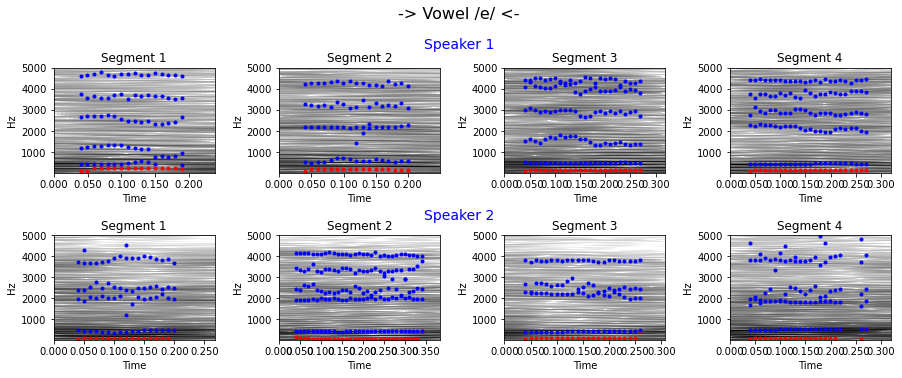

In [330]:
fig,a =  plt.subplots(2,4,figsize=(15,5))
plt.subplots_adjust(hspace = 0.6,wspace=0.4 )

fig.suptitle(f"-> Vowel /e/ <-", fontsize=16,y=1.05)  
plt.figtext(0.5,0.965, "Speaker 1", ha="center", va="top", fontsize=14, color="b")
plt.figtext(0.5,0.49, "Speaker 2", ha="center", va="top", fontsize=14, color="b")


for s in range(2):
    speaker = str(s+1)
    print(f"\n> Speaker no.{speaker}:")
    for i in range(4):
        recNum = str(i+1)
        file_name = f'../Media/s{speaker}/e{recNum}_s{speaker}.wav'
        pos = s*4+i%4
        pitch_formants = eh_pitch_formants[pos]
        print(f"Eh_{recNum}={len(pitch_formants)}")
        compount_pitch_formants_plot(file_name, pitch_formants, a[s][i], i)

     
    fig.savefig(f'../Plots/eh_s{speaker}.png', dpi=500)

In [332]:
# function for forming a matrix that incorporates 5-tuples of formants
# for each frame and for every recording of a vowel
def isolate_5_formant_stats(s):
    fmnts = np.zeros( ( len(s) , 5 ) )
    nnz = 0
    for i , k in enumerate( list( s.keys() ) ):
        a = s[k]
        tmp_arr = np.array(a['formants_freqs'])
        if tmp_arr.size == 5 and 0 not in tmp_arr:
            fmnts[i, :] = tmp_arr
            nnz += 1
    ret_fmnts = np.zeros( ( nnz , 5 ) )
    nnz = 0
    for i in range( fmnts.shape[0] ):
        if np.sum( fmnts[i,:] ) > 0:
            ret_fmnts[nnz, :] = fmnts[i,:]
            nnz += 1
    return ret_fmnts

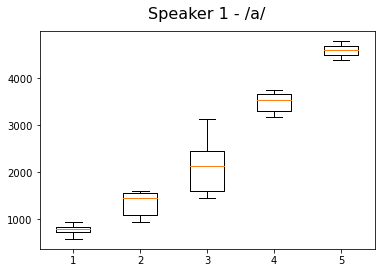

In [345]:
ah_stacked = isolate_5_formant_stats( ah_pitch_formants[0] )
for i in range( 1, 4 ):
    ah_stacked = np.vstack( ( ah_stacked , isolate_5_formant_stats( ah_pitch_formants[i] ) ) )

_ = plt.boxplot( ah_stacked )
plt.title("Speaker 1 - /a/",fontsize=16,y=1.03)
plt.savefig('../Plots/ah_boxplot_s1.png', dpi=500)

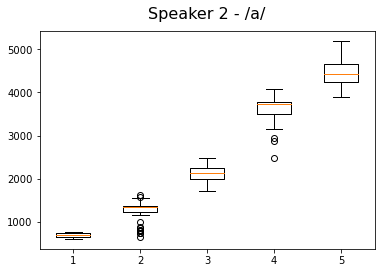

In [346]:
ah_stacked = isolate_5_formant_stats( ah_pitch_formants[4] )
for i in range( 5, 8 ):
    ah_stacked = np.vstack( ( ah_stacked , isolate_5_formant_stats( ah_pitch_formants[i] ) ) )

_ = plt.boxplot( ah_stacked )
plt.title("Speaker 2 - /a/",fontsize=16,y=1.03)
plt.savefig('../Plots/ah_boxplot_s2.png', dpi=500)

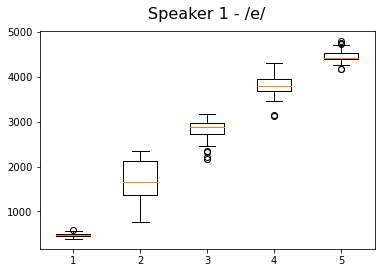

In [347]:
eh_stacked = isolate_5_formant_stats( eh_pitch_formants[0] )
for i in range( 1, 4, 1 ):
    eh_stacked = np.vstack( ( eh_stacked , isolate_5_formant_stats( eh_pitch_formants[i] ) ) )

_ = plt.boxplot( eh_stacked )
plt.title("Speaker 1 - /e/",fontsize=16,y=1.03)
plt.savefig('../Plots/eh_boxplot_s1.png', dpi=500)

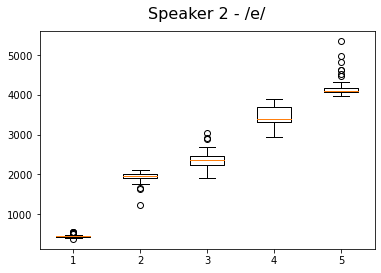

In [348]:
eh_stacked = isolate_5_formant_stats( eh_pitch_formants[4] )
for i in range( 5, 8 ):
    eh_stacked = np.vstack( ( eh_stacked , isolate_5_formant_stats( eh_pitch_formants[i] ) ) )

_ = plt.boxplot( eh_stacked )
plt.title("Speaker 2 - /e/",fontsize=16,y=1.03)
plt.savefig('../Plots/eh_boxplot_s2.png', dpi=500)

## Part 2b

Χρησιμοποιώντας τα απαραίτητα τμήματα του κώδικα από τη σελίδα https://github.com/maximoskp /MSc_LangTech_NKUA_DSP/blob/master/5_speech_synthesis_basics.ipynb να κάνετε σύνθεση ενός φωνήεντος με θεμελιώδη/εις συχνότητα/ες της επιλογής σας για κάθε μία/έναν από τους δύο ομιλητές.

In [350]:
import numpy as np
import numpy.matlib
import librosa
import matplotlib.pyplot as plt
import sounddevice as sd
import time

In [361]:
# run batch
file_names = ['../Media/s1/a1_s1.wav',
              '../Media/s1/a2_s1.wav',
              '../Media/s1/a3_s1.wav',
              '../Media/s1/a4_s1.wav',
              '../Media/s1/e1_s1.wav',
              '../Media/s1/e2_s1.wav',
              '../Media/s1/e3_s1.wav',
              '../Media/s1/e4_s1.wav']

# file_names = ['../Media/s2/a1_s2.wav',
#               '../Media/s2/a2_s2.wav',
#               '../Media/s2/a3_s2.wav',
#               '../Media/s2/a4_s2.wav',
#               '../Media/s2/e1_s2.wav',
#               '../Media/s2/e2_s2.wav',
#               '../Media/s2/e3_s2.wav',
#               '../Media/s2/e4_s2.wav']

sythesized = np.zeros(0)
recorded = np.zeros(0)


for i, file_name in enumerate(file_names):
    y, sr = librosa.load(file_name, sr=44100)
    
    pitch = librosa.yin(y, 50, 1000)
    fr = np.mean(pitch)
    
    n_fft = 8096
    hop_size = 256
    
    p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
    d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    m = np.mean( d , axis=1 )
    m -= np.min( m )
    
    def moving_average(x, w):
        x = np.hstack( ( x[0]*np.ones(w//2) , x , x[-1]*np.ones(w//2-1) ) )
        ma = np.convolve(x, np.ones(w), 'valid') / w
        return ma
    
    a = moving_average(m,50)
    a /= np.max( a )
    
    # filter
    f = numpy.matlib.repmat( a , p.shape[1], 1 ).T
    
    # make saw
    n = np.arange( y.size )
    x = (n%(sr/fr))/(sr/fr)
    xp = librosa.stft(x, n_fft=n_fft, hop_length=hop_size)
    
    px = xp*f
    x1 = librosa.istft(px, hop_length=hop_size)
    
    dpx = librosa.amplitude_to_db( np.abs(px), ref=np.max )
    
    sythesized = np.hstack( (sythesized,x1) )
    recorded = np.hstack( (recorded,y) )

sd.play( recorded, sr )
time.sleep( recorded.size/sr + 0.5 )
sd.play( sythesized , sr )